## Import Library 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import seaborn as sns
import numpy as np
from torch.utils.data import random_split
from torchvision import models
import torchvision as tv
import torch.optim as optim

In [ ]:
BATCH_SIZE=24 
# BATCH_SIZE= 128
num_epochs= 10 
weight_decay=1e-4
learning_rate = 0.001 
class_size=10

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Loading and Preparing Data

In [ ]:
transform = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(p=0.7),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                ])

In [ ]:
train_dataset = tv.datasets.CIFAR10(root="./", train=True, transform=transform, download=True)
test_dataset = tv.datasets.CIFAR10(root="./", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


## Loading VGG16 Network

In [ ]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)
# print(vgg16)

### change classifier 

In [ ]:
classes_list = list(vgg16.classifier)
new_class_list = []

new_class_list.append(nn.Dropout())
new_class_list.append(nn.Linear(in_features=25088, out_features=4096, bias=True))
new_class_list.append(nn.ReLU(inplace=True))
new_class_list.append(nn.Dropout())
new_class_list.append(nn.Linear(in_features=4096, out_features=4096, bias=True))
new_class_list.append(nn.ReLU(inplace=True))
new_class_list.append(nn.Linear(in_features=4096, out_features=10, bias=True))

vgg16.classifier = nn.Sequential(*new_class_list)

In [ ]:
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### add 1 Dropout layer on vgg.classifier with p = 0.3

In [ ]:
model_new_test = torchvision.models.vgg16(pretrained=True)
model_new_test.to(device)
classes_list = list(model_new_test.classifier)
new_classes_list = []
new_classes_list.append(nn.Dropout(p=0.3, inplace=True))
for cls in classes_list:
    new_classes_list.append(cls)

# modify convolution layers
model_new_test.classifier = nn.Sequential(*new_classes_list)

In [ ]:
print(model_new_test)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### change feature (after the Conv2d layer, add a batchnorm 2d layer and at the end of the feature layer, add a layer AvgPool2d) -> future work 

In [ ]:
model_new_fea = torchvision.models.vgg16(pretrained=True)
# model_new_fea.to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
fea_vgg16 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

def make_layer(fea_vgg16):
  layers = []
  in_channels = 3
  for x in fea_vgg16:
    if x == 'M':
      layers += [nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]
    else:
      layers += [nn.Conv2d(in_channels, x, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                 nn.BatchNorm2d(x),
                 nn.ReLU(inplace=True)]
      in_channels = x
  layers += [nn.AvgPool2d(kernel_size=(1, 1), stride=(1, 1))]
  return nn.Sequential(*layers)

model_new_fea.features = make_layer(fea_vgg16)

# model_new_fea.classifier = nn.Sequential(nn.Linear(512, 10))

In [ ]:
model_new_fea.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Change the number of classes

In [ ]:
# model_new_test.classifier[6].out_features = 10
model_new_fea.classifier[6].out_features = 10

### Freeze convolution weights (vgg.feature)

In [ ]:
# for param in model_new.features.parameters():
#     param.requires_grad = False

for param in vgg16.features.parameters():
    param.requires_grad = False

### Optimizer and Loss Function

In [ ]:
# optimizer
# optimizer = optim.SGD(model_new_test.classifier.parameters(), lr=0.0005, momentum=0.9, weight_decay=0.001)
optimizer = torch.optim.Adam(model_new_fea.classifier.parameters(), lr=0.001, weight_decay= 5e-4) 

# loss function
criterion = nn.CrossEntropyLoss()

## Training and Testing Functions

In [ ]:
def test(model, test_dataloader):
    model.eval()
    test_running_loss = 0.0

    total = len(test_loader.dataset)

    test_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        test_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        test_running_correct += (preds == target).sum().item()
    
    test_loss = test_running_loss/len(test_dataloader.dataset)
    test_accuracy = 100. * test_running_correct/len(test_dataloader.dataset)

    return test_loss, test_accuracy

In [ ]:
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    print()
    
    return train_loss, train_accuracy

In [ ]:
import torch
torch.cuda.empty_cache()

torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [ ]:
import torch.backends.cudnn as cudnn
model = model_new_fea.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

In [ ]:
print(model)

DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0

In [ ]:
train_loss , train_accuracy = [], []
test_loss , test_accuracy = [], []

for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = fit(model, train_loader)
    test_epoch_loss, test_epoch_accuracy = test(model, test_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    test_loss.append(test_epoch_loss)
    test_accuracy.append(test_epoch_accuracy)

In [ ]:
def test_correct():
  total = len(test_loader.dataset)
  val_running_correct = 0
  model = model_new_fea.to(device)
  # model.load_state_dict(torch.load(MODEL_NAME))
  model.eval()
  for int, data in enumerate(test_loader):
    data, target = data[0].to(device), data[1].to(device)
    output = model(data)
    loss = criterion(output, target)
        
    _, preds = torch.max(output.data, 1)
    val_running_correct += (preds == target).sum().item()
    
    val_accuracy = 100. * val_running_correct/len(test_loader.dataset)

  print("correct", val_running_correct)
  print("total:", total)
  print("accuracy:", val_accuracy)

test_correct()

correct 8675
total: 10000
accuracy: 86.75


In [ ]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# from utils import progress_bar
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # progress_bar(batch_idx, len(train_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #              % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

        train_data_loss = train_loss/len(trainloader.dataset)
        train_data_accuracy = 100. * correct/len(trainloader.dataset)
        print(f'Train Loss: {train_data_loss:.4f}, Train Acc: {train_data_accuracy:.2f}')

In [ ]:
import os
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
def test_make(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

In [ ]:
best_acc

90.59

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import seaborn as sns
import numpy as np
from torch.utils.data import random_split
from torchvision import models
import torchvision as tv
import torch.optim as optim


cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x.to(device))
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


net = VGG('VGG16')
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
import torch.backends.cudnn as cudnn
# net = SimpleDLA()
# net = model_new_fea.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
for epoch in range(start_epoch, start_epoch+200):
    train(epoch)
    test_make(epoch)
    scheduler.step()

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Train Loss: 0.0000, Train Acc: 27.65
Train Loss: 0.0000, Train Acc: 27.90
Train Loss: 0.0000, Train Acc: 28.16
Train Loss: 0.0000, Train Acc: 28.41
Train Loss: 0.0000, Train Acc: 28.67
Train Loss: 0.0000, Train Acc: 28.93
Train Loss: 0.0000, Train Acc: 29.18
Train Loss: 0.0000, Train Acc: 29.44
Train Loss: 0.0000, Train Acc: 29.69
Train Loss: 0.0000, Train Acc: 29.95
Train Loss: 0.0000, Train Acc: 30.21
Train Loss: 0.0000, Train Acc: 30.46
Train Loss: 0.0000, Train Acc: 30.72
Train Loss: 0.0000, Train Acc: 30.97
Train Loss: 0.0000, Train Acc: 31.23
Train Loss: 0.0000, Train Acc: 31.49
Train Loss: 0.0000, Train Acc: 31.74
Train Loss: 0.0000, Train Acc: 32.00
Train Loss: 0.0000, Train Acc: 32.25
Train Loss: 0.0000, Train Acc: 32.51
Train Loss: 0.0000, Train Acc: 32.77
Train Loss: 0.0000, Train Acc: 33.02
Train Loss: 0.0000, Train Acc: 33.28
Train Loss: 0.0000, Train Acc: 33.53
Train Loss: 0.0000, Train Acc: 33.79
Train Loss: 0.0000

## Training tune  

### train giữ nguyên các lớp, lr = 0.001, optim = SGD => acc train ~ 98%, acc test ~ 87% => overfit nặng 

### thêm 1 Dropout layer với p = 0.2, lr = 0.001, optim=SGD => chưa fix được overfit 

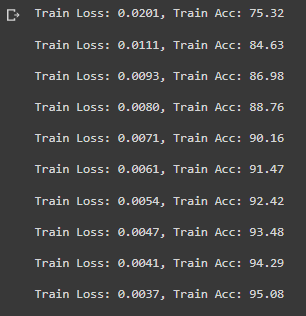



---

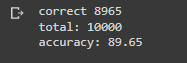

### thay đổi phần classifier (chuyển dropout layer ở vị trí [5] ->lên vị trí [0]) + optimizer = SGD (lr=0.001, weight_decay=5e-4), epochs=10 => hết overfit, tuy nhiên test acc giảm còn khoảng 82% 

 
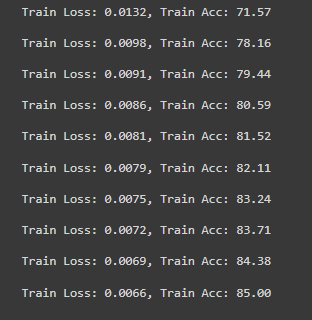

---
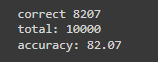


### giữ nguyên các lớp, epochs = 10, adam với lr = 0.0005 và weight_decay=0.001 

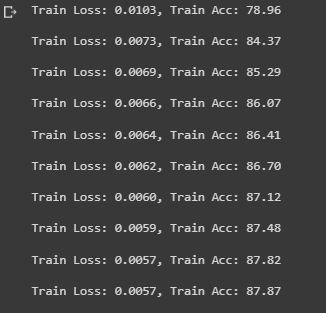

---
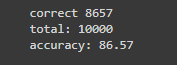

### giữ nguyên các lớp mạng + đóng băng lớp feature + optimizer = adam, lr=0.0005, epochs=15, weight_decay=0.001

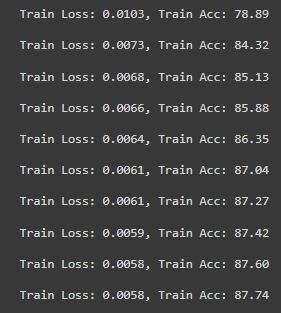


---



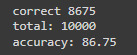

### thêm 1 dropout layer p = 0.3, adam với lr=0.0005 và weight_decay = 0.001 và epochs = 8 

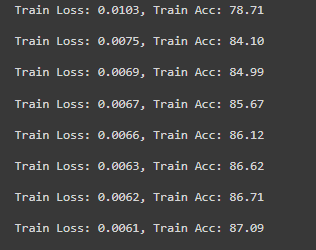

---


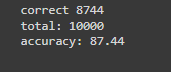

## Plot Acc + Loss 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Problem1_labwork4/test_5
MODEL_NAME = "cifar_vgg16_test5.pth"
torch.save(model_new_test.state_dict(), MODEL_NAME)

/content/drive/MyDrive/Problem1_labwork4/test_5


In [ ]:
import matplotlib.pyplot as plt

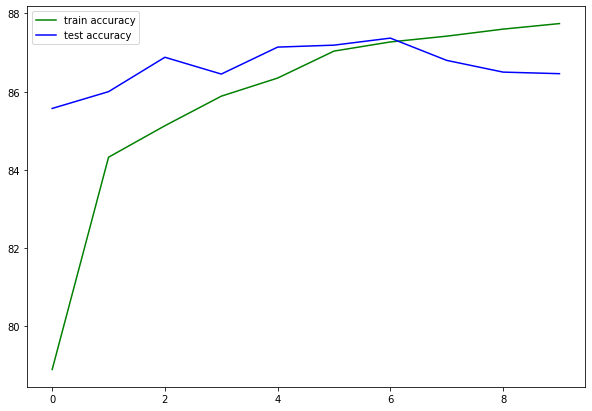

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='test accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

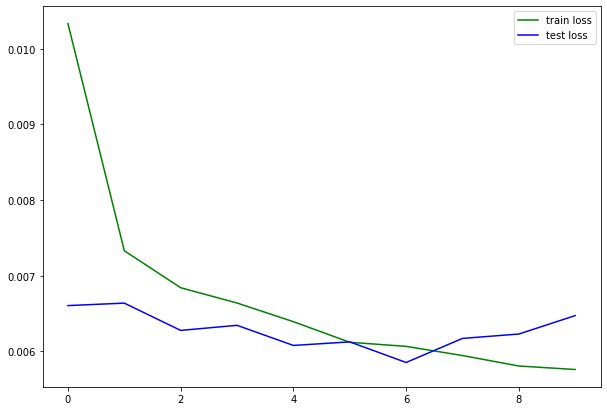

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='green', label='train loss')
plt.plot(val_loss, color='blue', label='test loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

## Train

In [ ]:
def train():
  n_total_step = len(train_loader)
  for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
      imgs = imgs.to(device)
      labels = labels.to(device)

      labels_hat = vgg16(imgs)
      n_corrects = (labels_hat.argmax(axis=1)==labels).sum().item()

      loss_value = criterion(labels_hat, labels)
      loss_value.backward()

      optimizer.step()
      optimizer.zero_grad()
      if (i+1)%250 == 0:
        print(f'epoch {epoch+1}/{num_epochs}, step: {i+1}/{n_total_step}: loss = {loss_value:.5f}, acc = {100*(n_corrects/labels.size(0)):.2f}%')
    print()

In [ ]:
def test():
  with torch.no_grad():
    number_corrects = 0
    number_samples = 0

    for i, (test_img_set, test_label_set) in enumerate(test_loader):
      test_img_set = test_img_set.to(device)
      test_label_set = test_label_set.to(device)

      y_pred = vgg16(test_img_set)

      labels_pred = y_pred.argmax(axis=1)

      number_corrects += (labels_pred==test_label_set).sum().item()
      number_samples += test_label_set.size(0)

    print("correct", number_corrects)
    print("total:", number_samples)
    print("accuracy:", (number_corrects/number_samples)*100)

In [ ]:
train()

epoch 1/5, step: 250/1250: loss = 0.61202, acc = 82.50%
epoch 1/5, step: 500/1250: loss = 0.93944, acc = 65.00%
epoch 1/5, step: 750/1250: loss = 0.91650, acc = 65.00%
epoch 1/5, step: 1000/1250: loss = 0.58580, acc = 80.00%
epoch 1/5, step: 1250/1250: loss = 0.71885, acc = 80.00%

epoch 2/5, step: 250/1250: loss = 0.44972, acc = 82.50%
epoch 2/5, step: 500/1250: loss = 0.29496, acc = 90.00%
epoch 2/5, step: 750/1250: loss = 0.40755, acc = 85.00%
epoch 2/5, step: 1000/1250: loss = 0.64463, acc = 75.00%
epoch 2/5, step: 1250/1250: loss = 0.56226, acc = 75.00%

epoch 3/5, step: 250/1250: loss = 0.41430, acc = 82.50%
epoch 3/5, step: 500/1250: loss = 0.18336, acc = 92.50%
epoch 3/5, step: 750/1250: loss = 0.33842, acc = 87.50%
epoch 3/5, step: 1000/1250: loss = 0.40119, acc = 90.00%
epoch 3/5, step: 1250/1250: loss = 0.50797, acc = 87.50%

epoch 4/5, step: 250/1250: loss = 0.26608, acc = 90.00%
epoch 4/5, step: 500/1250: loss = 0.22733, acc = 90.00%
epoch 4/5, step: 750/1250: loss = 0.241

In [ ]:
test()

correct 8666
total: 10000
accuracy: 86.66


## Save model

In [ ]:
torch.save(model.state_dict(), "cifar10_vgg16_model.pth") #SAVES THE TRAINED MODEL
model = VGG16_NET()

## Accurancy for each class 

In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         outputs = model_new_test(images)
#         _, predictions = torch.max(outputs, 1)
#         # collect the correct predictions for each class
#         for label, prediction in zip(labels, predictions):
#             if label == prediction:
#                 correct_pred[classes[label]] += 1
#             total_pred[classes[label]] += 1



total = len(test_loader.dataset)
val_running_correct = 0
model = model_new_test.to(device)
model.load_state_dict(torch.load(MODEL_NAME))
# model.eval()

with torch.no_grad():
  for int, data in enumerate(test_loader):
    data, target = data[0].to(device), data[1].to(device)
    output = model(data)
    # loss = criterion(output, target)
    
  _, preds = torch.max(output.data, 1)
  # val_running_correct += (preds == target).sum().item()
  # val_accuracy = 100. * val_running_correct/len(test_loader.dataset)

  for label, prediction in zip(target, preds):
    if label == prediction:
      correct_pred[classes[label]] += 1
    total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / (total_pred[classname] + 0.00001)
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')